# U-Net

<img src="images/UNet.JPG" width=800>

The image above illustrates the initial design outlined in the paper. However, we are going to implement a slightly different version of it with our own adjustments.

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Model

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


DoubleConv(in_channels=128, out_channels=256)(torch.randn(32, 128, 32, 32)).shape

torch.Size([32, 256, 32, 32])

In [3]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


Down(in_channels=128, out_channels=256)(torch.randn(32, 128, 32, 32)).shape

torch.Size([32, 256, 16, 16])

In [4]:
class Up(nn.Module):
    def __init__(self, start_channels, out_channels):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(start_channels, start_channels//2, kernel_size=2, stride=2)
        self.dconv = DoubleConv(start_channels, out_channels)

    def forward(self, input, skip):
        input = self.upsample(input)
        x = torch.cat([skip, input], dim=1)

        return self.dconv(x)


Up(start_channels=256, out_channels=128)(
    input=torch.randn(32, 256, 16, 16), skip=torch.randn(32, 128, 32, 32)
).shape

torch.Size([32, 128, 32, 32])

In [5]:
class UNet(nn.Module):
    def __init__(self, img_channels):
        super().__init__()

        self.dconv1 = DoubleConv(img_channels, out_channels=8)
        self.down1 = Down(in_channels=8, out_channels=16)
        self.down2 = Down(in_channels=16, out_channels=32)
        self.down3 = Down(in_channels=32, out_channels=64)
        self.down4 = Down(in_channels=64, out_channels=128)

        self.up1 = Up(start_channels=128, out_channels=64)
        self.up2 = Up(start_channels=64, out_channels=32)
        self.up3 = Up(start_channels=32, out_channels=16)
        self.up4 = Up(start_channels=16, out_channels=8)

        self.to_rgb = nn.Conv2d(in_channels=8, out_channels=img_channels, kernel_size=1)

    def forward(self, img):
        skip1 = self.dconv1(img)
        skip2 = self.down1(skip1)
        skip3 = self.down2(skip2)
        skip4 = self.down3(skip3)

        last_down_out = self.down4(skip4)

        out = self.up1(last_down_out, skip4)
        out = self.up2(out, skip3)
        out = self.up3(out, skip2)
        out = self.up4(out, skip1)

        out = self.to_rgb(out)

        return out


UNet(img_channels=1)(torch.randn(32, 1, 64, 64)).shape

torch.Size([32, 1, 64, 64])

## Denoising Images using U-Net

### Dataset

In [8]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
mnist_dataset = torchvision.datasets.MNIST('data/mnist', train=True, transform=transform, download=False)

In [9]:
class AddNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return x + torch.randn_like(x) * self.std + self.mean

In [10]:
class DenoisingMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_transform=AddNoise(mean=0., std=.5)):
        super().__init__()

        self.clean_dataset = mnist_dataset
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.clean_dataset)

    def __getitem__(self, index):
        clean_img = self.clean_dataset[index][0]

        return self.noise_transform(clean_img), clean_img

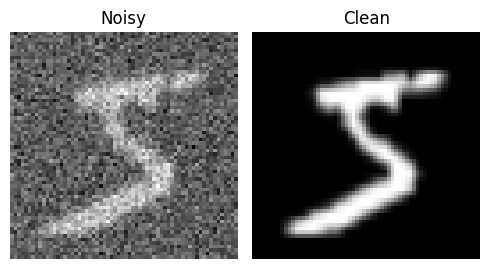

In [11]:
train_dataset = DenoisingMNISTDataset(mnist_dataset)

fig, axs = plt.subplots(1, 2, figsize=(5, 3))

disturbed_img, clean_img = train_dataset[0]

for i, title in enumerate(["Noisy", "Clean"]):
  axs[i].axis('off')
  axs[i].set_title(title)
axs[0].imshow(disturbed_img.permute(1, 2, 0), cmap='gray')
axs[1].imshow(clean_img.permute(1, 2, 0), cmap='gray')
plt.tight_layout()

### Train

In [12]:
def visualize_predictions(model, device, test_dataset, title=None, num_images_to_display=10):
    disturbed_images = torch.stack([test_dataset[i][0] for i in range(num_images_to_display)])
    clean_images = torch.stack([test_dataset[i][1] for i in range(num_images_to_display)])
    pred = model(disturbed_images.to(device)).detach().cpu()

    fig, axs = plt.subplots(3, num_images_to_display, figsize=(num_images_to_display, 3))

    if title is not None:
        fig.suptitle(title)
    for idx, label in enumerate(["Clean", "Disturbed", "Prediction"]):
        axs[idx][0].set_ylabel(label)

    for i in range(num_images_to_display):
        for j, imgs in enumerate([clean_images, disturbed_images, pred]):
            axs[j][i].tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[j][i].imshow(imgs[i].permute(1, 2, 0), cmap='gray')

    plt.show()

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model = UNet(img_channels=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

test_dataset = DenoisingMNISTDataset(torchvision.datasets.MNIST('data/mnist', train=False, transform=transform, download=False))

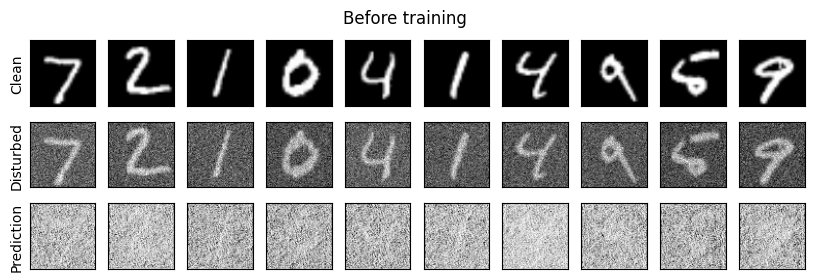

In [15]:
visualize_predictions(model, device, test_dataset, title=f"Before training")

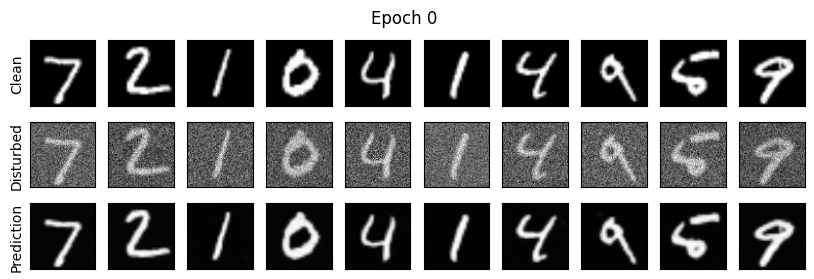

In [16]:
num_epochs = 1

for epoch in range(num_epochs):
    train_loss = 0.
    for disturbed_images, clean_images in train_loader:
        disturbed_images, clean_images = disturbed_images.to(device), clean_images.to(device)
        pred = model(disturbed_images)
        loss = criterion(pred, clean_images)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * disturbed_images.shape[0]

    train_loss /= len(train_loader.dataset)

    visualize_predictions(model, device, test_dataset, title=f"Epoch {epoch}")